In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [27]:
# Load ECG data
data = pd.read_csv("ecg_data_summary.csv")
data = data.dropna()

# Select features
features = ["Age", "BPM", "Average_RR_Interval", "Min_RR_Interval", 
            "Max_RR_Interval", "PT_Interval", "RR_Median"]
X = data[features].values
Y = data["Arrhythmia"].astype(int).values

# Normalizing the features
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

# One-hot encode
def one_hot(y):
    out = np.zeros((len(y), 2))
    for i in range(len(y)):
        out[i][y[i]] = 1
    return out

Y = one_hot(Y)

# Train-test splitting
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = [x.reshape(1, -1) for x in X_train]
X_test = [x.reshape(1, -1) for x in X_test]

In [28]:
# Creating Neural Network

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def f_forward(x, w1, w2):
    z1 = x.dot(w1)
    a1 = sigmoid(z1)
    z2 = a1.dot(w2)
    a2 = sigmoid(z2)
    return a2

def loss(out, y):
    return np.sum((out - y)**2) / len(y)

def generate_wt(x, y):
    return np.random.randn(x, y)

def back_prop(x, y, w1, w2, alpha):
    z1 = x.dot(w1)
    a1 = sigmoid(z1)
    z2 = a1.dot(w2)
    a2 = sigmoid(z2)

    d2 = a2 - y
    d1 = np.multiply((d2.dot(w2.T)), a1 * (1 - a1))

    w2_adj = a1.T.dot(d2)
    w1_adj = x.T.dot(d1)

    w1 -= alpha * w1_adj
    w2 -= alpha * w2_adj

    return w1, w2

In [29]:
# Initializing Weights
input_size = len(features)
hidden_size = 30
output_size = 2

w1 = generate_wt(input_size, hidden_size)
w2 = generate_wt(hidden_size, output_size)

In [30]:
# Training
def train(x_data, y_data, w1, w2, alpha=0.05, epochs=100):
    acc_list = []
    loss_list = []

    for epoch in range(epochs):
        losses = []
        for i in range(len(x_data)):
            out = f_forward(x_data[i], w1, w2)
            losses.append(loss(out, y_data[i]))
            w1, w2 = back_prop(x_data[i], y_data[i], w1, w2, alpha)

        avg_loss = sum(losses) / len(losses)
        acc = (1 - avg_loss) * 100
        print(f"Epoch {epoch+1} => Accuracy: {acc:.2f}% | Loss: {avg_loss:.4f}")
        acc_list.append(acc)
        loss_list.append(avg_loss)
    return acc_list, loss_list, w1, w2

accs, losses, w1, w2 = train(X_train, Y_train, w1, w2, alpha=0.05, epochs=100)

Epoch 1 => Accuracy: 82.25% | Loss: 0.1775
Epoch 2 => Accuracy: 82.76% | Loss: 0.1724
Epoch 3 => Accuracy: 82.98% | Loss: 0.1702
Epoch 4 => Accuracy: 83.08% | Loss: 0.1692
Epoch 5 => Accuracy: 83.16% | Loss: 0.1684
Epoch 6 => Accuracy: 83.21% | Loss: 0.1679
Epoch 7 => Accuracy: 83.25% | Loss: 0.1675
Epoch 8 => Accuracy: 83.27% | Loss: 0.1673
Epoch 9 => Accuracy: 83.30% | Loss: 0.1670
Epoch 10 => Accuracy: 83.32% | Loss: 0.1668
Epoch 11 => Accuracy: 83.33% | Loss: 0.1667
Epoch 12 => Accuracy: 83.34% | Loss: 0.1666
Epoch 13 => Accuracy: 83.35% | Loss: 0.1665
Epoch 14 => Accuracy: 83.36% | Loss: 0.1664
Epoch 15 => Accuracy: 83.37% | Loss: 0.1663
Epoch 16 => Accuracy: 83.37% | Loss: 0.1663
Epoch 17 => Accuracy: 83.38% | Loss: 0.1662
Epoch 18 => Accuracy: 83.38% | Loss: 0.1662
Epoch 19 => Accuracy: 83.39% | Loss: 0.1661
Epoch 20 => Accuracy: 83.39% | Loss: 0.1661
Epoch 21 => Accuracy: 83.40% | Loss: 0.1660
Epoch 22 => Accuracy: 83.40% | Loss: 0.1660
Epoch 23 => Accuracy: 83.40% | Loss: 0.16

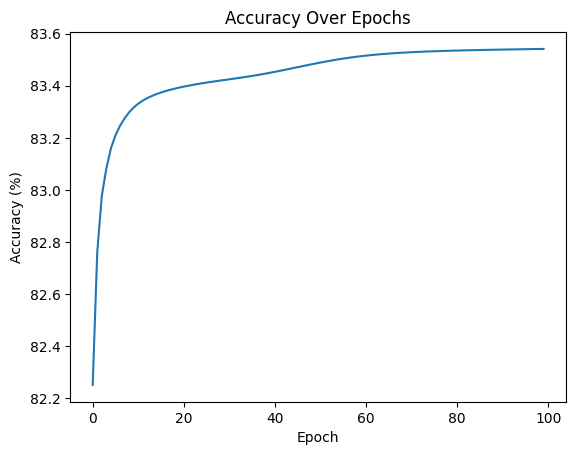

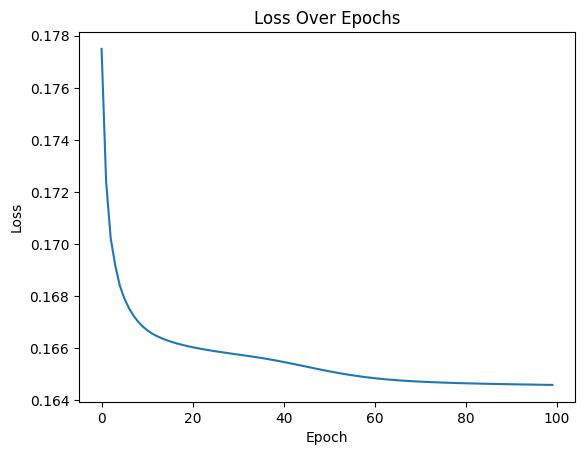

In [31]:
# Accuracy and Loss
plt.plot(accs)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()

plt.plot(losses)
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [32]:
# Prediction and Evaluation
def predict(x, w1, w2):
    out = f_forward(x, w1, w2)
    return np.argmax(out)

y_pred = [predict(x, w1, w2) for x in X_test]
y_true = [np.argmax(y) for y in Y_test]

def precision_recall_f1(y_true, y_pred):
    tp = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    tn = sum((yt == 0 and yp == 0) for yt, yp in zip(y_true, y_pred))
    fp = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
    fn = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    accuracy = (tp + tn) / len(y_true)
    return accuracy, precision, recall, f1

acc, prec, rec, f1 = precision_recall_f1(y_true, y_pred)
print(f"\nFinal Evaluation Metrics:\nAccuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1 Score: {f1:.4f}")


Final Evaluation Metrics:
Accuracy: 0.7790
Precision: 0.7798
Recall: 0.9985
F1 Score: 0.8757
